In [1]:
import json
from abc import ABC, abstractmethod
from dataclasses import dataclass

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from QHyper.problems.algorithms.solver_utils import WorkflowSchedulingSolverDecorator, \
    DecomposedWorkflowSchedulingSolver, WorkflowSchedule
from QHyper.problems.algorithms.workflow_decomposition import SeriesParallelSplitFinal
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingOneHot
from QHyper.solvers import Gurobi, solver_from_config

In [2]:
class ExperimentResult(ABC):
    @abstractmethod
    def plot(self):
        pass


@dataclass
class AlgorithmRun:
    max_subgraph_size: int
    decomposition_schedule: WorkflowSchedule
    reference_schedule: WorkflowSchedule


class Experiment(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline

    def _get_decomposed_solver(self, max_graph_size: int):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = SeriesParallelSplitFinal().decompose(workflow, max_graph_size)
        problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
        solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
        return DecomposedWorkflowSchedulingSolver(list(solvers), division)

    def _get_solver(self):
        solver_config = {
            "problem": {
                "type": "workflow_scheduling",
                "encoding": "one-hot",
                "tasks_file": self.tasks_file,
                "machines_file": self.machines_file,
                "deadline": self.deadline,
            },
            "solver": {
                "type": "gurobi",
            }
        }

        return WorkflowSchedulingSolverDecorator(solver_from_config(solver_config))

    def _schedule(self, max_subgraph_size: int) -> AlgorithmRun:
        return AlgorithmRun(
            max_subgraph_size,
            self._get_decomposed_solver(max_subgraph_size).solve(),
            self._get_solver().solve()
        )

    @abstractmethod
    def run(self) -> ExperimentResult:
        pass


def deadline_as_cpv(tasks_file, machines_file):
    workflow = Workflow(tasks_file, machines_file, 100000)
    return int(workflow.critical_path_value)

In [3]:
class MssInfluenceExperiment(Experiment):
    def __init__(self, tasks_file, machines_file, max_subgraph_sizes: list[int]):
        super().__init__(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
        self.max_subgraph_sizes: list[int] = max_subgraph_sizes

    class MssInfluenceExperimentResult(ExperimentResult):
        def __init__(self, algorithm_runs: list[AlgorithmRun]):
            self.algorithm_runs = algorithm_runs
            self.cost_increase_per_mss = self._get_result_dict()

        def _get_result_dict(self) -> dict[int, float]:
            result = {}
            for algorithm_run in self.algorithm_runs:
                result[algorithm_run.max_subgraph_size] = self._calculate_cost_increase_ratio(algorithm_run)
            return result

        @staticmethod
        def _calculate_cost_increase_ratio(algorithm_run: AlgorithmRun) -> float:
            return algorithm_run.decomposition_schedule.cost / algorithm_run.reference_schedule.cost

        def plot(self, title: str = None):
            fig, ax = plt.subplots(1, 1, figsize=(15, 6))
            ax.plot(self.cost_increase_per_mss.keys(), self.cost_increase_per_mss.values(), 'o-', linewidth=2)
            ax.set_xlabel('Max subgraph size')
            ax.set_ylabel('Relative schedule cost increase')
            if title:
                ax.set_title(title)
            plt.show()
            
        def save_as_json(self, filename: str):
            with open(filename, 'w') as file:
                json.dump(obj=self.cost_increase_per_mss, fp=file, indent=4)

    def run(self) -> ExperimentResult:
        schedules = []
        for mss in self.max_subgraph_sizes:
            try:
                schedules.append(self._schedule(mss))
            except Exception as e:
                print(f"Unable to solve for max subgraph size = {mss}")
        return self.MssInfluenceExperimentResult(schedules)  

In [4]:
def measure_mss_influence_for_workflow_family(workflows: list[str], machines_file: str, divisions: list[float]):
    experiment_results: dict[int, MssInfluenceExperiment.MssInfluenceExperimentResult] = {}
    for tasks_file in workflows:
        workflow_size = len(Workflow(tasks_file, machines_file, 100000).tasks)
        max_subgraph_sizes = [int(multiplier * workflow_size) for multiplier in divisions]
        max_subgraph_sizes = [mss for mss in max_subgraph_sizes if mss >= 2]
        mss_influence_experiment = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
        experiment_results[workflow_size] = mss_influence_experiment.run()
    return experiment_results

def plot_for_family(family, experiment_results, divisions, save: bool = True):
    fig, ax = plt.subplots(1, 1, figsize=(18,8))
    
    for size, r in experiment_results.items():
        x = [int(mss * 100) for mss in divisions[:len(r.cost_increase_per_mss.values())]]
        y = [(cost_increase - 1) * 100.0 for cost_increase in r.cost_increase_per_mss.values()]
        ax.plot(x, y, 'o-', linewidth=2, label=f'{size} nodes')
    
    ax.set_xticks([int(division * 100) for division in divisions])
    ax.set_xticklabels(ax.get_xticks(), fontsize=12)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))
    ax.set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=12)
    ax.set_ylabel('Schedule cost increase relative to scheduling without division [%]', fontsize=12)
    ax.set_title(f'Influence of the max subgraph size on the schedule cost for {family} workflows', fontsize=15)
    
    plt.legend(fontsize=12)
    plt.show()
    
    if save:
        fig.savefig(f"mss_influence_results/{family}/cost_increase_plot.png")

def save_family_as_json(family, experiment_results):
    for size, experiment_result in experiment_results.items():
        experiment_result.save_as_json(f"mss_influence_results/{family}/{size}.json")

# Epigenomics family

In [10]:
workflows = [
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [11]:
%%capture
epigenomics_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_45540/2454088944.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


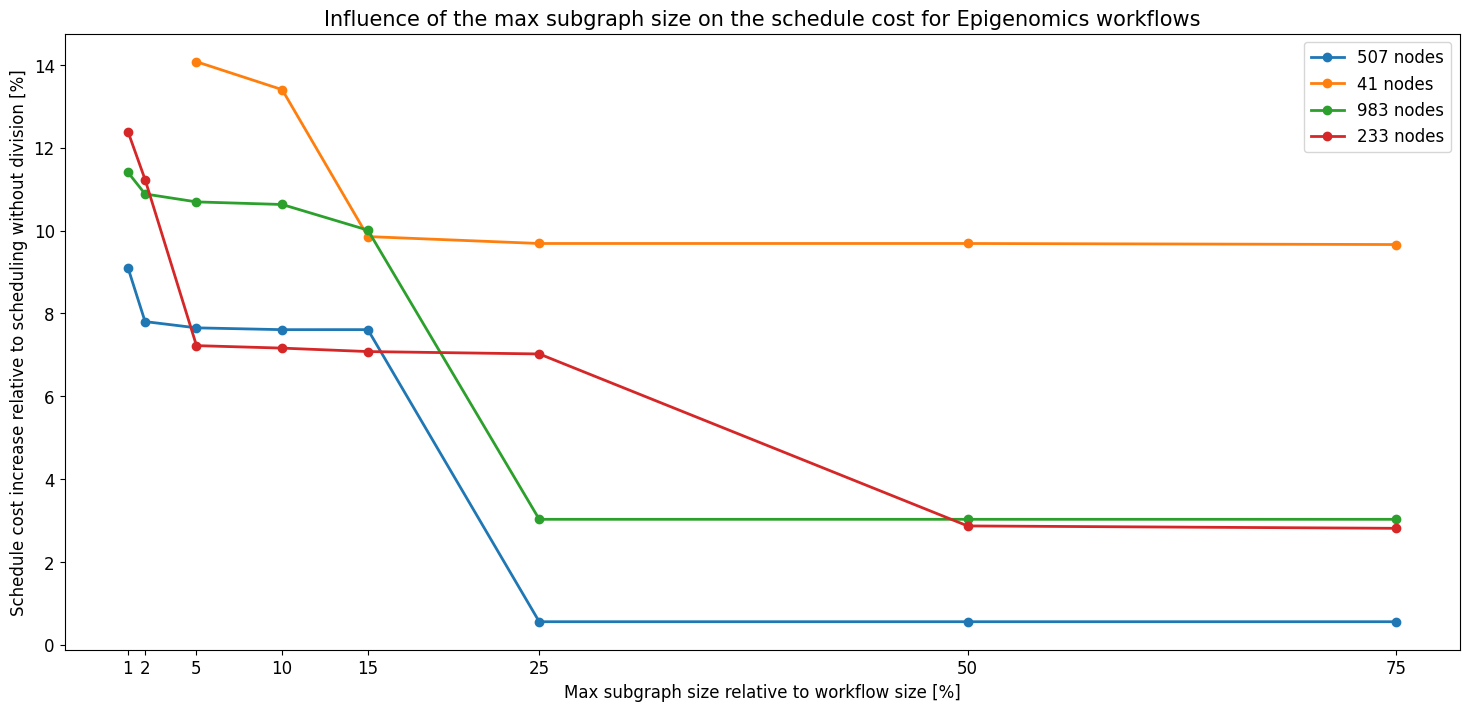

In [13]:
plot_for_family("Epigenomics", epigenomics_results, divisions)

In [14]:
save_family_as_json("Epigenomics", epigenomics_results)

# 1000genome

In [15]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-100k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-2ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-6ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [16]:
%%capture
family_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_45540/2454088944.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


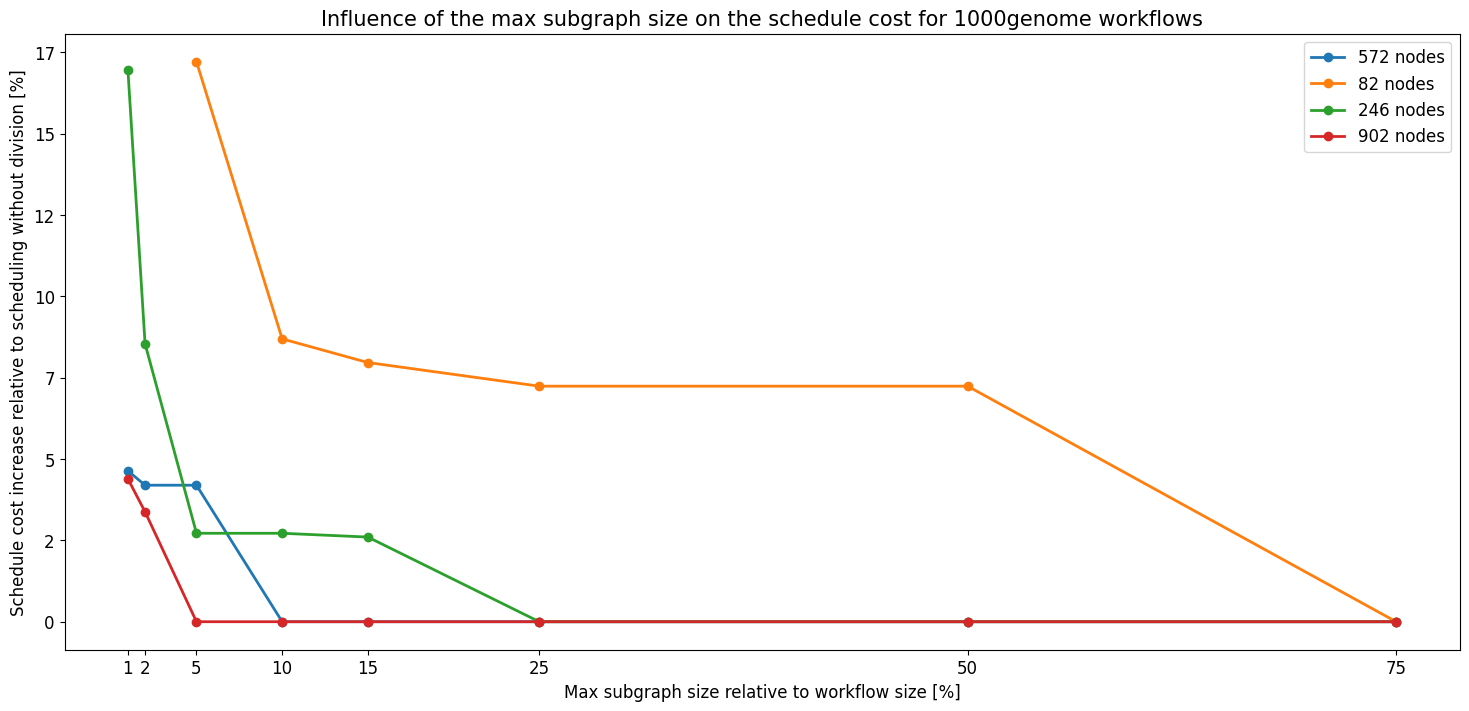

In [18]:
plot_for_family("1000genome", family_results, divisions)

In [19]:
save_family_as_json("1000genome", family_results)

# SRA Search

In [5]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-20a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [6]:
%%capture
sra_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_45540/2454088944.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


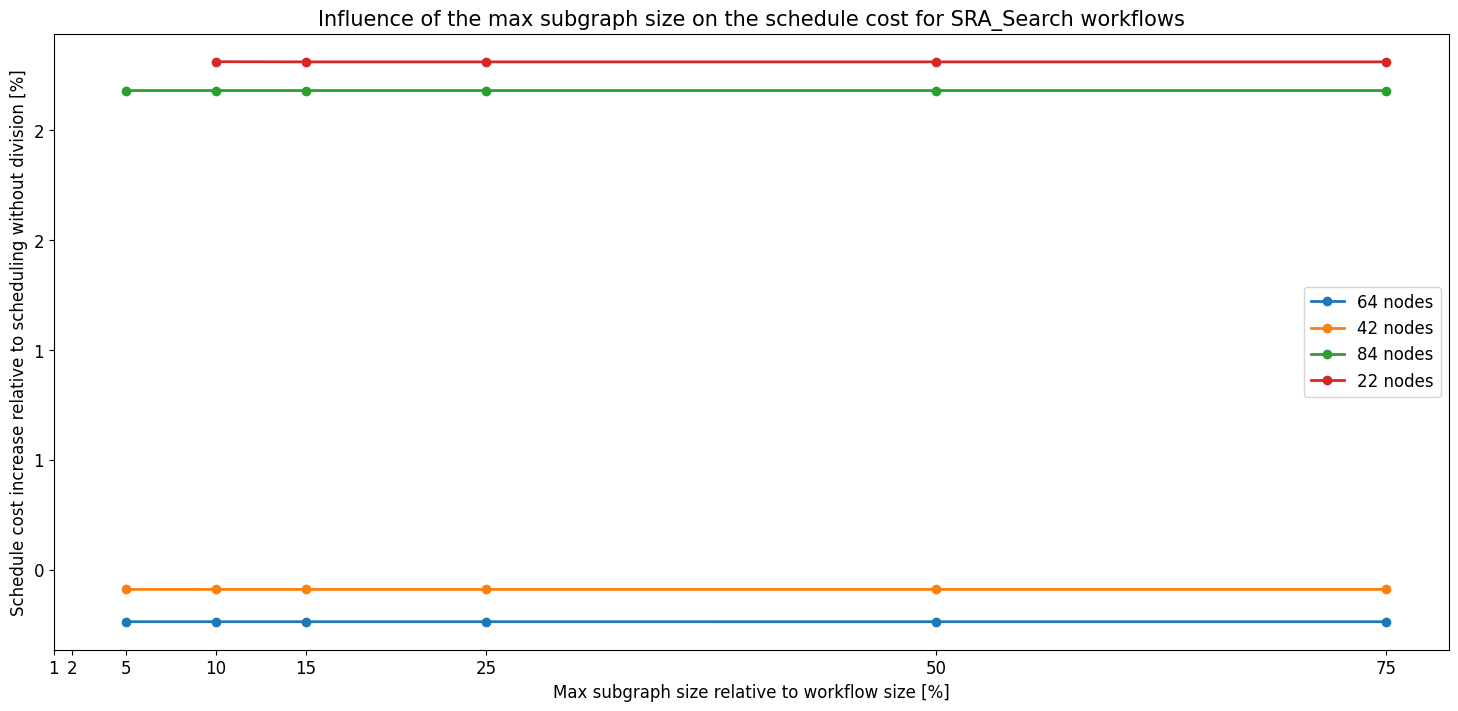

In [7]:
plot_for_family("SRA_Search", sra_results, divisions)

In [9]:
save_family_as_json("SRA_Search", sra_results)

# Tests

In [82]:
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]
mss = [d * 84 for d in divisions]
print(mss)

[63.0, 42.0, 21.0, 12.6, 8.4, 4.2, 1.68, 0.84]


In [83]:
tasks_file = "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json"
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
workflow = Workflow(tasks_file, machines_file, 100000)
print(workflow.critical_path_value)

24081.97130605714


In [7]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json"
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
max_subgraph_sizes = np.linspace(2, 37, 8, dtype=int)

mss_epigenomics_41 = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
experiment_result = mss_epigenomics_41.run()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x2b54a928
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [8e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros
Variable types: 0 continuous, 6 integer (6 binary)
Found heuristic solution: objective 35.1339792

Root relaxation: objective 3.324732e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

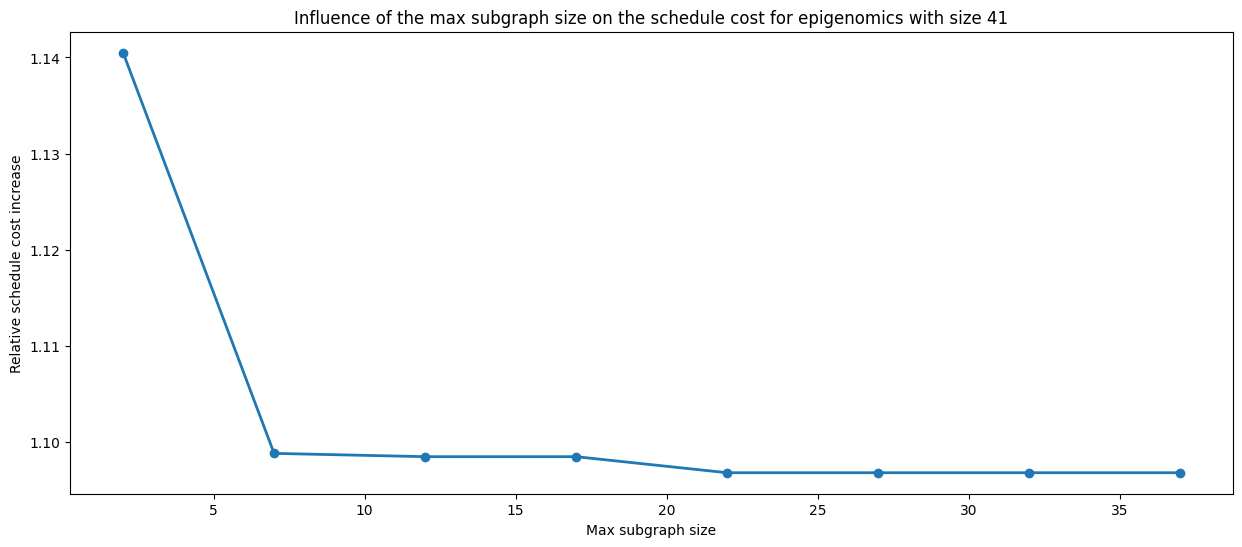

In [9]:
experiment_result.plot("Influence of the max subgraph size on the schedule cost for epigenomics with size 41")

In [10]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
max_subgraph_sizes = np.linspace(2, 233, 8, dtype=int)

mss_epigenomics_233 = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
experiment_result = mss_epigenomics_233.run()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0x0d96cad2
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [8e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1251.81 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.251806400000e+03, best bound 1.251806400000e+03, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Solution count 1: 395.117 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.951168000000e+02, best bound 3.951168000000e+02, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0x39beea29
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [7e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 65.8944 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.589440000000e+0

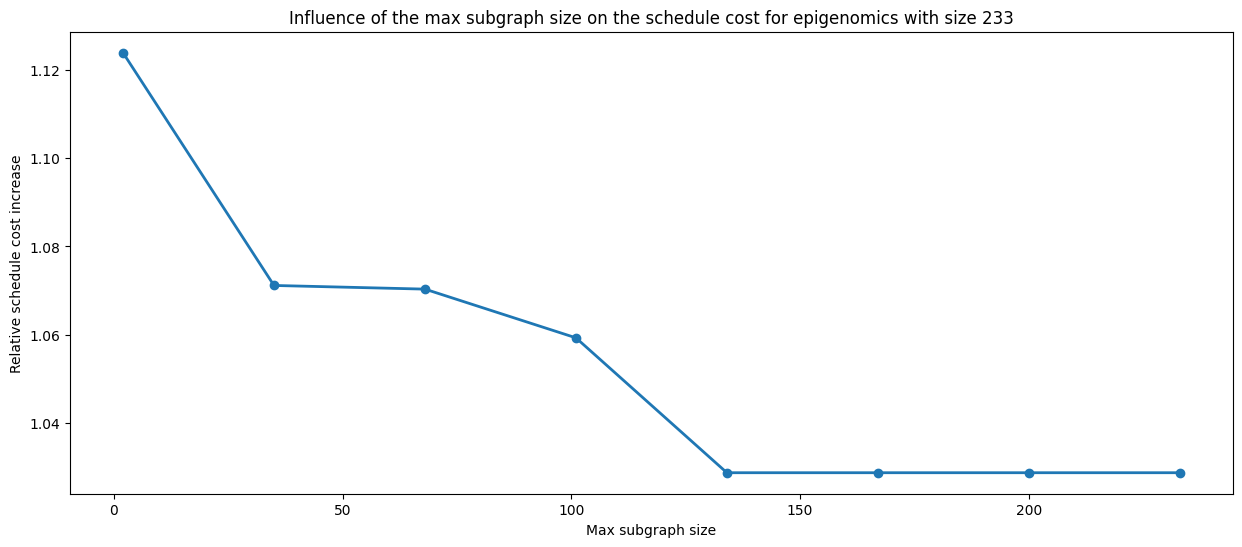

In [11]:
experiment_result.plot("Influence of the max subgraph size on the schedule cost for epigenomics with size 233")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0x1bdc60fe
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1228.41 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.228409702400e+03, best bound 1.228409702400e+03, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Solution count 1: 1123.79 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.123790400000e+03, best bound 1.123790400000e+03, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0xf7e87a36
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [5e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 53.6588 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.365875840000e+01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0x11049b02
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 279.097 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.790970272000e+02, best bound 2.790970272000e+02, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [7e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 3 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 101.157 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.011571200000e+02, best bound 1.011571200000e+02, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 10 columns and 15 nonzeros
Model fingerprint: 0x58015008
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4

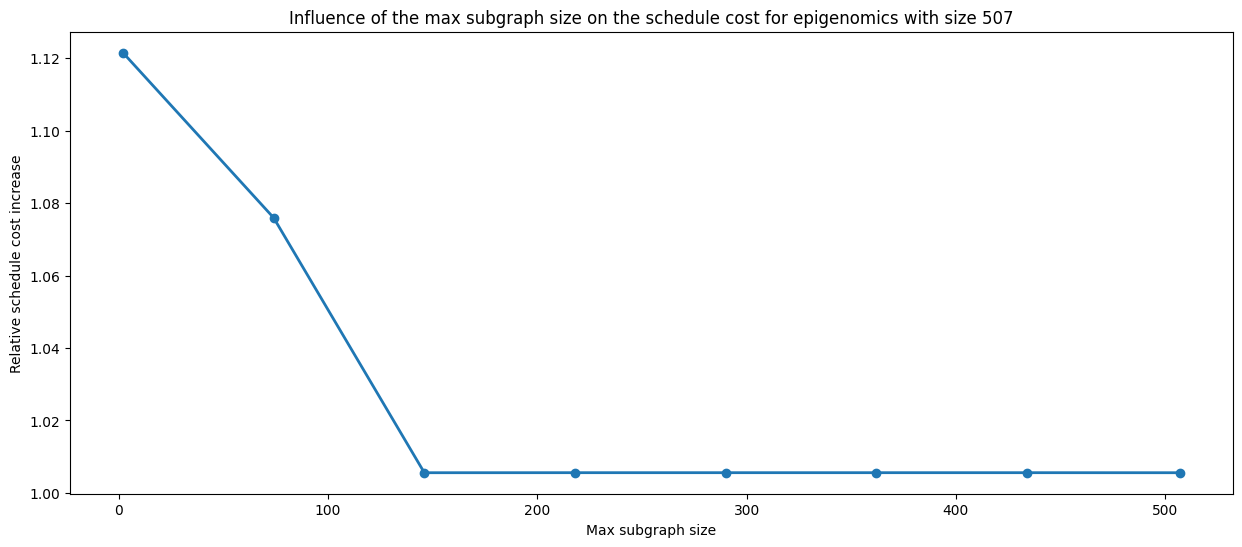

In [12]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-100k-001.json"
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
max_subgraph_sizes = np.linspace(2, 507, 8, dtype=int)

mss_epigenomics_507 = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
experiment_result = mss_epigenomics_507.run()
experiment_result.plot("Influence of the max subgraph size on the schedule cost for epigenomics with size 507")

In [43]:
int(1.7)

1